In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, RocCurveDisplay

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

from PIL import Image
import os

In [2]:
path ='data/' #set here data directory

In [3]:
# def count_files_in_directory([directory_path]):
#     return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])


# print(count_files_in_directory('data/train/predator'))

In [4]:
#TODO Refactor - split for methods
def get_files_size():
    width = []
    heigth = []
    for direct in os.listdir(path):
        if direct != '.DS_Store': # applicable to MacOS
            for folder in os.listdir(os.path.join(path,direct)):
                if folder != '.DS_Store':
                    for file in os.listdir(os.path.join(path,direct ,folder)):
                        if file != '.DS_Store':
                            width.append(Image.open(os.path.join(path,direct ,folder, file)).size[0])
                            heigth.append(Image.open(os.path.join(path,direct ,folder, file)).size[0])
    return width, heigth

In [5]:
#Mean size value from all pictures train+validation
width, heigth = get_files_size()
width = round(np.array(width).mean())
heigth =round(np.array(heigth).mean())
print(f'Dimensions for resize \nwidth: {width}')
print(f'heigth: {heigth}')

Dimensions for resize 
width: 250
heigth: 250


In [6]:
width = 250
heigth = 250
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((width,heigth)), 
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((width,heigth)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(os.path.join(path,'train'), data_transforms['train']),
    'validation': 
    datasets.ImageFolder(os.path.join(path, 'validation'), data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True), 
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False)
}

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [8]:
model_resnet18 = models.resnet18(weights=True).to(device)
    
for param in model_resnet18.parameters():
    param.requires_grad = False   
    
model_resnet18.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
class MultiClassCNN(nn.Module):
    def __init__(self):
        super(MultiClassCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # no activation function here as we'll use CrossEntropyLoss which has softmax built-in
        return x
model_MCCNN = MultiClassCNN().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.fc.parameters())

## Train

In [11]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [12]:
%%time
optimizer = optim.Adam(model_resnet18.fc.parameters())
model_resnet18 = train_model(model_resnet18, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
train loss: 0.5095, acc: 0.7363
validation loss: 0.3762, acc: 0.8250
Epoch 2/20
----------
train loss: 0.3295, acc: 0.8573
validation loss: 0.3022, acc: 0.8750
Epoch 3/20
----------
train loss: 0.2331, acc: 0.9078
validation loss: 0.2662, acc: 0.8850
Epoch 4/20
----------
train loss: 0.2047, acc: 0.9121
validation loss: 0.3450, acc: 0.8350
Epoch 5/20
----------
train loss: 0.2976, acc: 0.8746
validation loss: 0.2344, acc: 0.9050
Epoch 6/20
----------
train loss: 0.1772, acc: 0.9294
validation loss: 0.3522, acc: 0.8300
Epoch 7/20
----------
train loss: 0.2214, acc: 0.9078
validation loss: 0.2366, acc: 0.9050
Epoch 8/20
----------
train loss: 0.1924, acc: 0.9236
validation loss: 0.3161, acc: 0.8550
Epoch 9/20
----------
train loss: 0.1583, acc: 0.9352
validation loss: 0.3109, acc: 0.8650
Epoch 10/20
----------
train loss: 0.1771, acc: 0.9207
validation loss: 0.2257, acc: 0.9050
Epoch 11/20
----------
train loss: 0.1412, acc: 0.9510
validation loss: 0.2100, acc: 0.92

In [13]:
%%time
optimizer = optim.Adam(model_MCCNN.parameters())
model_MCCNN = train_model(model_MCCNN, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
train loss: 0.7594, acc: 0.5403
validation loss: 0.6551, acc: 0.6150
Epoch 2/20
----------
train loss: 0.6722, acc: 0.6037
validation loss: 0.6229, acc: 0.6150
Epoch 3/20
----------
train loss: 0.6243, acc: 0.6628
validation loss: 0.5885, acc: 0.7050
Epoch 4/20
----------
train loss: 0.5862, acc: 0.7147
validation loss: 0.5461, acc: 0.6800
Epoch 5/20
----------
train loss: 0.5668, acc: 0.7378
validation loss: 0.5234, acc: 0.6850
Epoch 6/20
----------
train loss: 0.5429, acc: 0.7435
validation loss: 0.5512, acc: 0.6700
Epoch 7/20
----------
train loss: 0.5586, acc: 0.7205
validation loss: 0.5357, acc: 0.6850
Epoch 8/20
----------
train loss: 0.5171, acc: 0.7450
validation loss: 0.5138, acc: 0.7200
Epoch 9/20
----------
train loss: 0.5293, acc: 0.7450
validation loss: 0.5509, acc: 0.6750
Epoch 10/20
----------
train loss: 0.5023, acc: 0.7723
validation loss: 0.5183, acc: 0.6950
Epoch 11/20
----------
train loss: 0.4981, acc: 0.7666
validation loss: 0.5267, acc: 0.70

## Predict

In [14]:
test_img_paths = ["test/0.jpg",
                        "test/1.jpg",
                        "test/2.jpg",
                         ]
img_list = [Image.open(img_path) for img_path in test_img_paths]

In [15]:
def predict(model, img_list, device, transforms):
    model.eval()  # set the model to evaluation mode
    test_batch = torch.stack([transforms(img).to(device) for img in img_list])#Creating one tensor from list of tensors
    outputs = model(test_batch)
    probs = F.softmax(outputs, dim=1)  # apply softmax to get probabilities
    return probs.cpu().data.numpy()

In [16]:
predictions = predict(model_resnet18, img_list, device, data_transforms['validation']) #Using same preprocessing as for validation

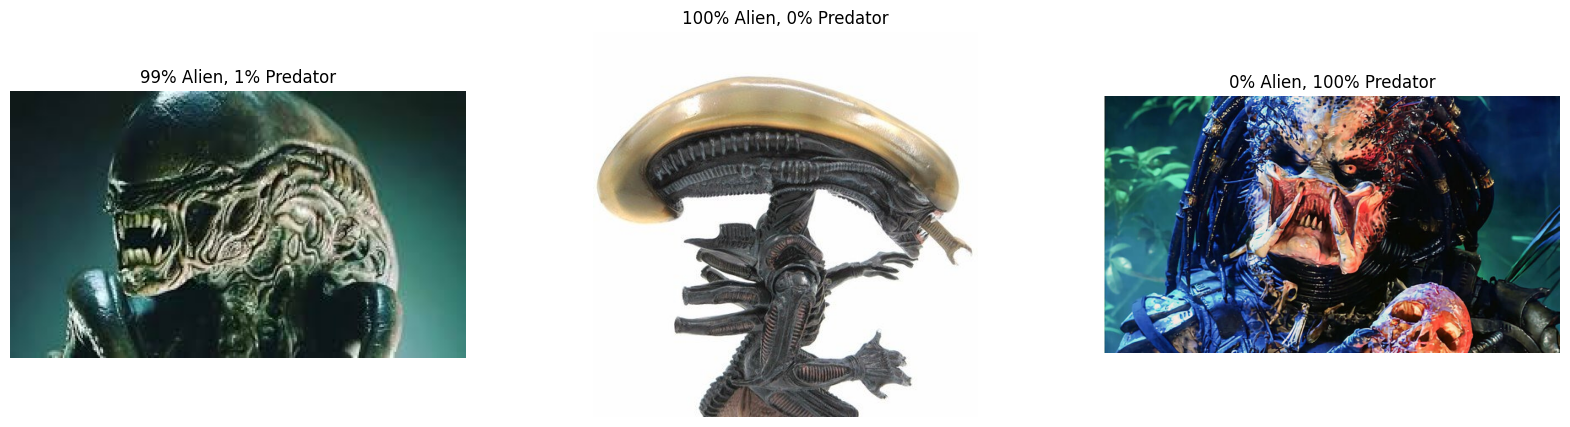

In [17]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*predictions[i,0],
                                                            100*predictions[i,1]))
    ax.imshow(img)

In [18]:
predictions = predict(model_MCCNN, img_list, device, data_transforms['validation']) #Using same preprocessing as for validation

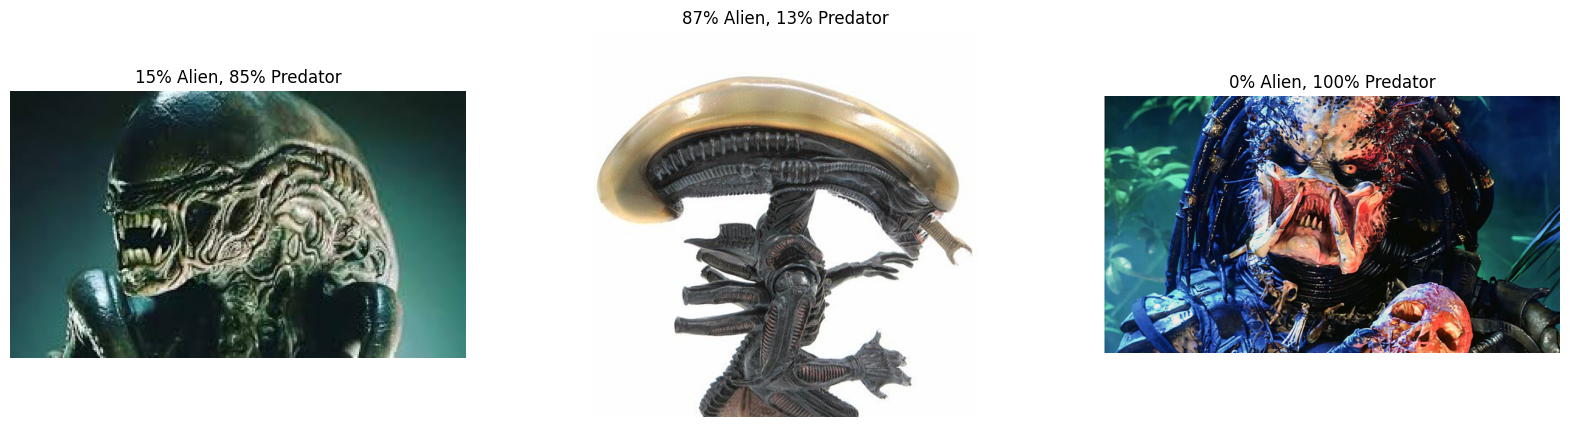

In [19]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*predictions[i,0],
                                                            100*predictions[i,1]))
    ax.imshow(img)